# Torch Autograd Implementation Case Study

1. Function High-Order Derivatives 
2. Neural Network gradient with respect to (input or weight)
3. Model-Agnostic Meta Learning (MAML)
4. Hessian of a neural network 
5. Implicit Neural Representation
6. Multiple Backwards

# 🔖 1. Torch High-order Derivates with create_graph

In [1]:
import torch 
v = -2.0
x = torch.tensor(v, requires_grad=True)

# function 
f = 2 * x**3
print(f"x={v},         f = {f}")

# first order
f.backward(retain_graph=True)
print(f"x={v},     df/dx = {x.grad}")

# second order
x.grad.zero_()
df = torch.autograd.grad(f, x, create_graph=True)[0]
df.backward(gradient=torch.tensor(1.0))
print(f"x={v}, d^2f/dx^2 = {x.grad}")

# thrid order
x.grad.zero_()
df = torch.autograd.grad(f, x, create_graph=True)[0]
ddf = torch.autograd.grad(df, x, create_graph=True)[0]
ddf.backward(gradient=torch.tensor(1.0))
print(f"x={v}, d^3f/dx^3 = {x.grad}")

# fourth order
x.grad.zero_()
df = torch.autograd.grad(f, x, create_graph=True)[0]
ddf = torch.autograd.grad(df, x, create_graph=True)[0]
dddf = torch.autograd.grad(ddf, x, create_graph=True)[0]
dddf.backward(gradient=torch.tensor(1.0))
print(f"x={v}, d^4f/dx^4 = {x.grad}")


x=-2.0,         f = -16.0
x=-2.0,     df/dx = 24.0
x=-2.0, d^2f/dx^2 = -24.0
x=-2.0, d^3f/dx^3 = 12.0
x=-2.0, d^4f/dx^4 = 0.0


You can check the result with the following equations

$$
\begin{aligned}
    \text{(function)~~~} &f = 2x^3 & \text{when~} x=-2 \Rightarrow 2 \cdot (-8) = -16 \\
    \text{(first-order)~~~} &\frac{df}{dx} = 6x^2 &  \text{when~} x=-2 \Rightarrow 6 \cdot 4 = 24 \\
    \text{(second-order)~~~} &\frac{d}{dx}\Big(\frac{df}{dx}\Big) = 12x & \text{when~} x=-2 \Rightarrow 12 \cdot 2 =24 \\
    \text{(third-order)~~~} &\frac{d}{dx}\Big(\frac{d^2f}{dx^2}\Big) = 12 &  \text{when~} x=-2 \Rightarrow 12 = 12 
\end{aligned}
$$

---

# 🔖 2. Neural Network 


$$
F = f(x)
$$ 

1. Gradient with respect to the input : 

$$\frac{dF}{dx}$$

2. Gradient with respect to the weight : 
$$\frac{dF}{d\theta}$$

3. Minimize the sum of squared of gradients 

$$
G = \sum_\theta \Big(\frac{dF}{d\theta} \Big)^2 
$$

In [2]:
import torch.nn as nn 

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.mlp = nn.Linear(2,5)
        self.out = nn.Linear(5, 1)
    def forward(self, x):
        x = self.mlp(x**2)
        x = nn.functional.relu(x)
        x = self.out(x)
        return x 

In [3]:
net = Net()
input= torch.tensor([1.0]*2, requires_grad=True)
params = [p for p in net.parameters() if len(p.size()) > 1]

# gradient with respect to the input
print("------------ Gradient with respect to the input")
f = net(input)
f.backward()
print(input.grad)


# gradient with respect to the weights 
print("------------ Gradient with respect to the weights")
input.grad.zero_() 
f = net(input)
gx = torch.autograd.grad(f, params, create_graph=True)[0]
for i in range(2):
    gx[i].sum().backward(retain_graph=True)
    print(input.grad)
    
# gradient of weights to minimize the sum of squared of the gradients
print("------------ Gradients to the sum of squqared gradients")
net.zero_grad()
f = net(input)
gx = torch.autograd.grad(f, params, create_graph=True)[0]
(gx**2).sum().backward()

print([p.grad for p in params])

------------ Gradient with respect to the input
tensor([0., 0.])
------------ Gradient with respect to the weights
tensor([0., 0.])
tensor([0., 0.])
------------ Gradients to the sum of squqared gradients
[tensor([[0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.]]), tensor([[0., 0., 0., 0., 0.]])]


---

# 🔖 3. MAML

Step 1. Compute the task specific updated weight 
$$
\theta' = \theta - \alpha \nabla_\theta L_{task} (f(\theta)) 
$$

Step 2. compute the meta-test with the computed weight
$$
\theta \leftarrow \theta - \nabla_\theta L_{{meta}} (f(\theta'))
$$

### Implementation 

1. autograd.grad($L$, $\theta$, $\mathrm{\textcolor{orange}{create\_graph=True}}$) computes $\nabla_\theta L$ as a tensor with computational graph

2. forward with weight - grad (obtained by 1) computes the step 2

In [4]:
import torch 
import torch.nn as nn 
import torch.nn.functional as F 

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.mlp = nn.Linear(2,5)
        self.out = nn.Linear(5, 1)
    def forward(self, x, fast_weights=None):
        if fast_weights is None:
            x = self.mlp(x)
            x = nn.functional.relu(x)
            x = self.out(x)
        else:  # same logit with given weight
            w, b = fast_weights[0], fast_weights[1]
            x = F.linear(x, w, b)
            x = nn.functional.relu(x)
            w, b = fast_weights[2], fast_weights[3]
            x = F.linear(x, w, b)
        return x 

net = Net()
lr=1e-3
meta_optim = torch.optim.Adam(net.parameters(), lr=lr)


meta_loss = 0
num_tasks = 3
for task in range(num_tasks):
    # Step 1 : compute one_step weight
    input= torch.tensor([(task+1.0)]*2)
    f = net(input)
    grad = torch.autograd.grad(f, net.parameters(), create_graph=True)    # Step 1 Core
    fast_weights = list(map(lambda p: p[1] - lr * p[0], zip(grad, net.parameters())))

    # Step 2 : compute the loss with one step weight
    meta_input= torch.tensor([(task+2.0)]*2)
    test_loss = net(input, fast_weights)      # Step 2 Core
    meta_loss += test_loss 

meta_loss /= num_tasks

# optimize theta parameters
meta_optim.zero_grad()
meta_loss.backward()
meta_optim.step()

---

# 🔖  4. Hessian 

Given the Hessian Matrix $H(\theta)_{N\times N}$ and vector $r$, 

the Hessian Vector product is computed by the gradient of the dot product between gradient and the vector. 

$$
\begin{aligned}
H(\theta) \cdot r &= \frac{d^2}{d\theta^2} \Big(  L(\theta) \Big) \cdot r \\
&= \frac{d}{d\theta} \Big( \frac{d}{d\theta} L(\theta) \cdot r \Big)

\end{aligned}
$$


#### Step 1. Compute the gradient 

#### Step 2. Compute the gradient times vector

In [5]:
net = Net()
params = [p for p in net.parameters() if len(p.size()) > 1]
N = sum(p.numel() for p in params)
print(f"Number of parameters : {N}")
print("Params", params)

# Compute the gardients
input= torch.tensor([(task+1.0)]*2)
f = net(input)
grad = torch.autograd.grad(f, inputs=params, create_graph=True)    # Step 1 Core

# Hessian Vector Product
prod = torch.autograd.Variable(torch.zeros(1)).type(type(grad[0].data))
vec = torch.rand_like(prod)
for (g,v) in zip(grad, vec):
    prod = prod + (g * v).cpu().sum()  # Step 2 Core
    
prod.backward()  # Now the params.grad stores the Hessian 

print("----------------------")
print("Hessian Vector Product")
for p in params:
    print(p.grad)

Number of parameters : 15
Params [Parameter containing:
tensor([[ 0.2750,  0.0939],
        [-0.1756,  0.0970],
        [-0.6907, -0.1596],
        [ 0.5345,  0.2078],
        [-0.6043, -0.3342]], requires_grad=True), Parameter containing:
tensor([[ 0.1577,  0.1482, -0.4240, -0.1805, -0.3069]], requires_grad=True)]
----------------------
Hessian Vector Product
tensor([[0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.]])
tensor([[4.0444, 0.0000, 0.0000, 4.0444, 0.0000]])


----

# 🔖 5. Implicit Neural Representation 

Image can be understood as a function of RGB colors over pixel positions 

$$
f: p(x,y) \rightarrow  (r,g,b)
$$

We can learn a function neural network $\phi \approx f$ 

1. Pixel Fitting  : compute the color at pixel position $p'$

$$
\mathcal{L} = ||f(p') - \phi(p')||^2
$$

2. Gradient Fitting  : compute the gradient of color at pixel position $p'$

$$
\mathcal{L} = ||\frac{df}{dp}\Big|_{p'} - \frac{d\phi(p)}{dp}\Big|_{p'}||^2
$$

In [28]:
import scipy 
def compute_image_gradient(im_array,  v=1):
    LENGTH = im_array.shape[1], im_array.shape[2]
    im_array = im_array.reshape(*LENGTH)
    
    grads_x = scipy.ndimage.sobel(im_array, axis=0)[..., None]
    grads_y = scipy.ndimage.sobel(im_array, axis=1)[..., None]
    magnitude = (2*2 + 1*4)
    grads_x /= (magnitude/LENGTH[0])
    grads_y /= (magnitude/LENGTH[1])
    return grads_x, grads_y


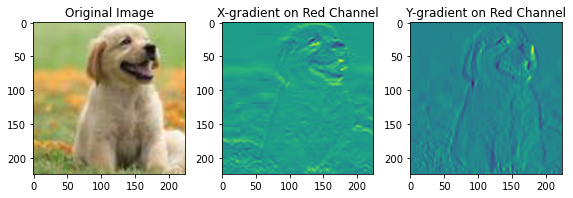

In [67]:
import torch
import torchvision.transforms as T 
from PIL import Image
import matplotlib.pyplot as plt 


# ------ Plot the Image Gradient  ------ 

t1 = T.Compose([
            # transforms.ToPILImage(),
            T.Resize(256),
            T.CenterCrop(224),  
        ])

t2 = T.ToTensor()

img_origin = Image.open('assets/dog.jpeg')
img_origin = t1(img_origin)
img =t2(img_origin).unsqueeze(0).numpy()

temp = img[:,0,:,:] # only the red color
grads_x, grads_y = compute_image_gradient(temp)
grads_x, grads_y = torch.from_numpy(grads_x), torch.from_numpy(grads_y)

# normalize 
x_grads = (grads_x - grads_x.min())/ (grads_x.max() - grads_x.min())
y_grads = (grads_y - grads_y.min())/ (grads_y.max() - grads_y.min())

fig, axes = plt.subplots(1,3, figsize=(8,3))

axes[0].imshow(img_origin)
axes[1].imshow(x_grads.numpy())
axes[2].imshow(y_grads.numpy())
axes[0].set_title("Original Image")
axes[1].set_title("X-gradient on Red Channel")
axes[2].set_title("Y-gradient on Red Channel")
plt.tight_layout()
plt.show()



In [56]:
class ImplicitNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer = nn.Sequential(
            nn.Linear(2, 64), # Input the x,y position
            nn.ReLU(),
            nn.Linear(64, 3)  # RGB prediction
        )
    def forward(self, x):
        x = x.clone().detach().requires_grad_(True)
        return self.layer(x), x
        
net = ImplicitNet()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-4)

# given: position(x,y) --> output: ColorPrediction, position
coordinates = torch.tensor([[0.5, 0.5]]) 
all_color_prediction, coordinates = net(coordinates)

# Matching the gradient 
# assume the ground truth gradient
gt = torch.rand(1, 2) 

loss = 0 
for channel in range(3):  # each R G B
    color_predict = all_color_prediction[:, channel]
    grad_predict = torch.autograd.grad(color_predict, 
                                       coordinates,    
                                       create_graph=True)[0]  # create_graph makes the optimization possible. 
    loss+= F.mse_loss(gt, grad_predict)
    
optimizer.zero_grad()
loss.backward()
optimizer.step()

# 6. Multiple Backwards

Given a common network and two separate paths, our goal is to backpropagate twice the common network 

In [3]:
import torch 
import torch.nn as nn 

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.common = nn.Linear(2, 3)
        
        self.net1 = nn.Sequential(
            nn.Linear(3, 5),
            nn.ReLU(),
            nn.Linear(5,1)
        )
        self.net2 = nn.Sequential(
            nn.Linear(3, 5),
            nn.ReLU(),
            nn.Linear(5,1)
        )   
        
    def forward(self, x):
        common = self.common(x)
        path1 = self.net1(common)
        path2 = self.net2(common)
        return path1, path2 
    

net = Net()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-4)
input = torch.rand(1, 2)

out_1, out_2 = net(input)

# optimize net1 and common
optimizer.zero_grad()
out_1.backward(retain_graph=True)  # Core Code for retaining computational graph
optimizer.step()

# optimize net2 and common (again)
optimizer.zero_grad()
out_2.backward()
optimizer.step()
